In [0]:
import folium
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import calendar



In [0]:
df=pd.read_csv("other-Lyft_B02510.csv")

df.info()
df.head()
df.describe()
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.dropna()
df = df.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267701 entries, 0 to 267700
Data columns (total 4 columns):
time_of_trip    267701 non-null object
start_lat       267700 non-null float64
start_lng       267700 non-null float64
Unnamed: 3      1198 non-null object
dtypes: float64(2), object(2)
memory usage: 8.2+ MB


In [0]:
df=df[:30000]
df.describe()

,start_lat,start_lng
count,30000.000000,30000.000000
mean,40.729608,-73.965960
std,0.043038,0.042287
min,40.559510,-74.186830
25%,40.708380,-73.990872
50%,40.732740,-73.978240
75%,40.755493,-73.952870
max,40.935400,-73.728940


In [0]:
df[['date','time']] = df.time_of_trip.str.split(" ",expand=True)
df.head()


,time_of_trip,start_lat,start_lng,date,time
0,9/4/2014 9:51,40.64705,-73.77988,9/4/2014,9:51
1,8/27/2014 21:13,40.74916,-73.98373,8/27/2014,21:13
2,9/4/2014 14:16,40.64065,-73.97594,9/4/2014,14:16
3,9/4/2014 16:08,40.75002,-73.99514,9/4/2014,16:08
4,8/28/2014 2:41,40.76715,-73.98636,8/28/2014,2:41


In [0]:
m = folium.Map([40.738720, -73.979090], zoom_start=11.5)

In [0]:
for index, row in df.iterrows():
    folium.CircleMarker([row['start_lat'], row['start_lng']],
                        radius=0.5,
                        fill_color="#30abd9", 
                       ).add_to(m)
m

In [0]:
heat = df[['start_lat', 'start_lng']].as_matrix()
# plot heatmap
m.add_children(plugins.HeatMap(heat, radius=12))
m

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


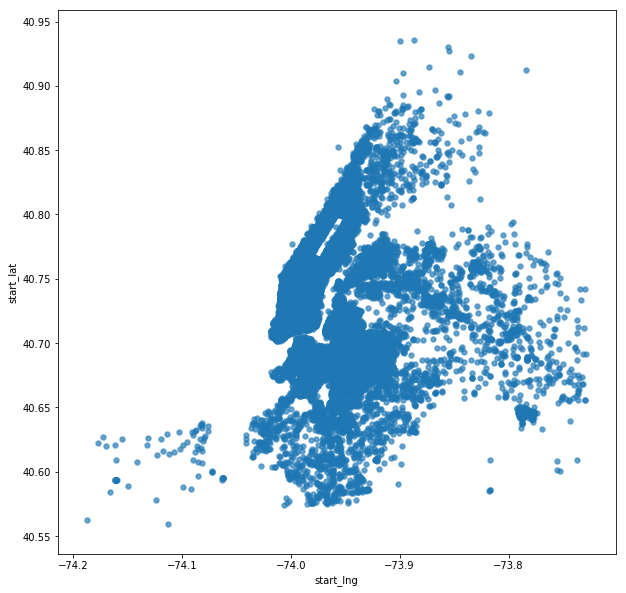

In [0]:
ax = df.plot(kind='scatter', x='start_lng', y='start_lat', alpha=0.6, linewidth=2,figsize=(10,10))
coords = df.as_matrix(columns=['start_lat', 'start_lng'])
cd=pd.DataFrame(df,columns=['start_lat','start_lng'])

In [0]:
coords = df.as_matrix(columns=['start_lat', 'start_lng'])
cd=pd.DataFrame(df,columns=['start_lat','start_lng'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


[0 1 1 ... 1 1 1]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, -1}
Number of samples=4,epsilon= 0.0055 Silhouette coefficient: 0.322


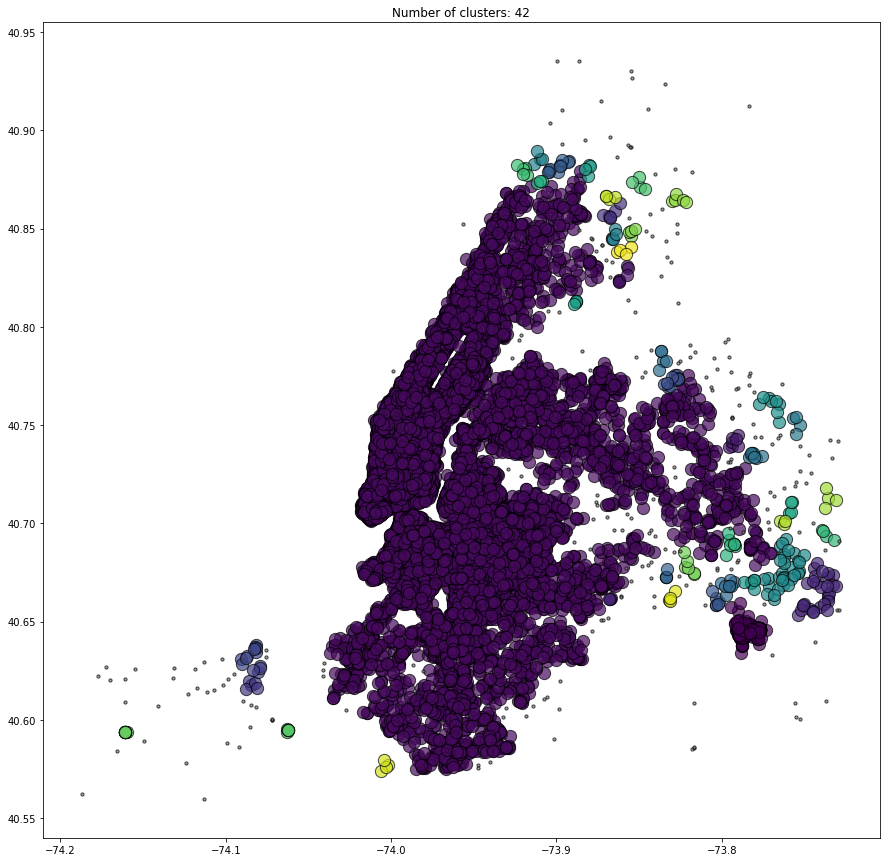

[0 1 1 ... 1 1 1]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, -1}
Number of samples=5,epsilon= 0.0055 Silhouette coefficient: 0.250


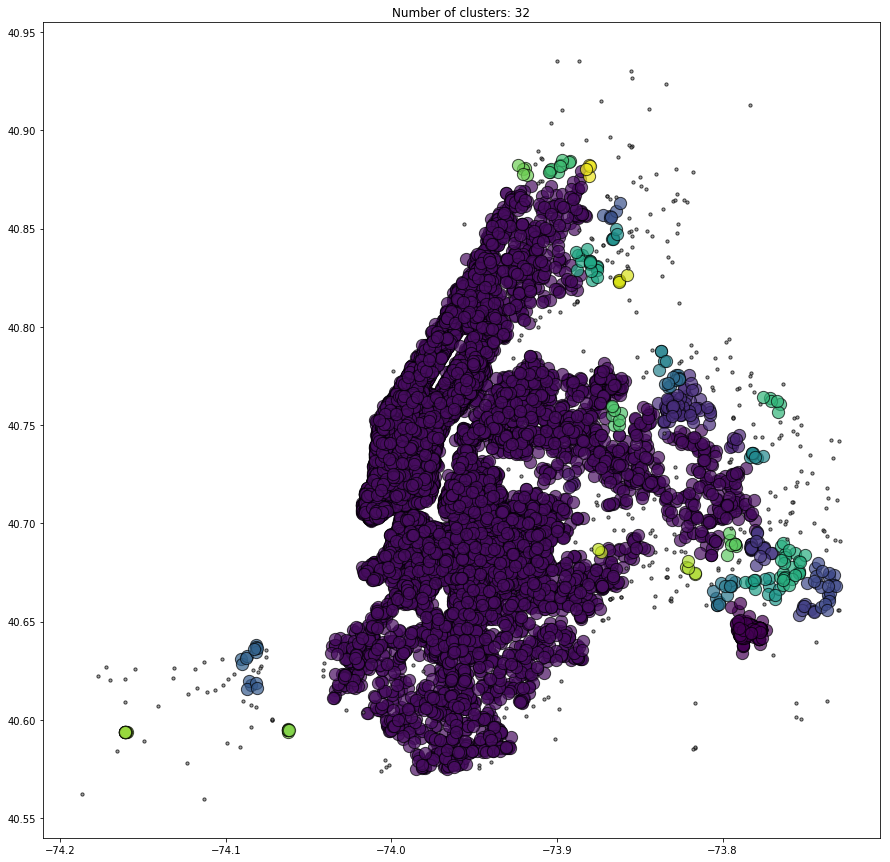

[0 0 0 ... 0 0 0]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, -1}
Number of samples=4,epsilon= 0.007 Silhouette coefficient: 0.397


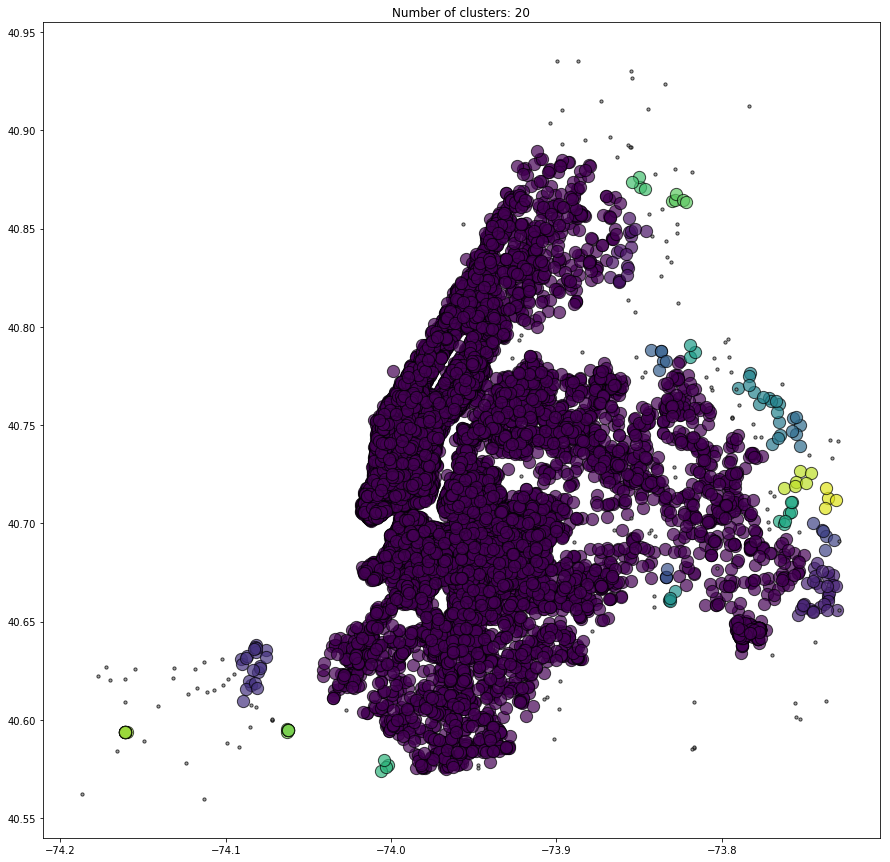

[0 1 1 ... 1 1 1]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, -1}
Number of samples=5,epsilon= 0.007 Silhouette coefficient: 0.448


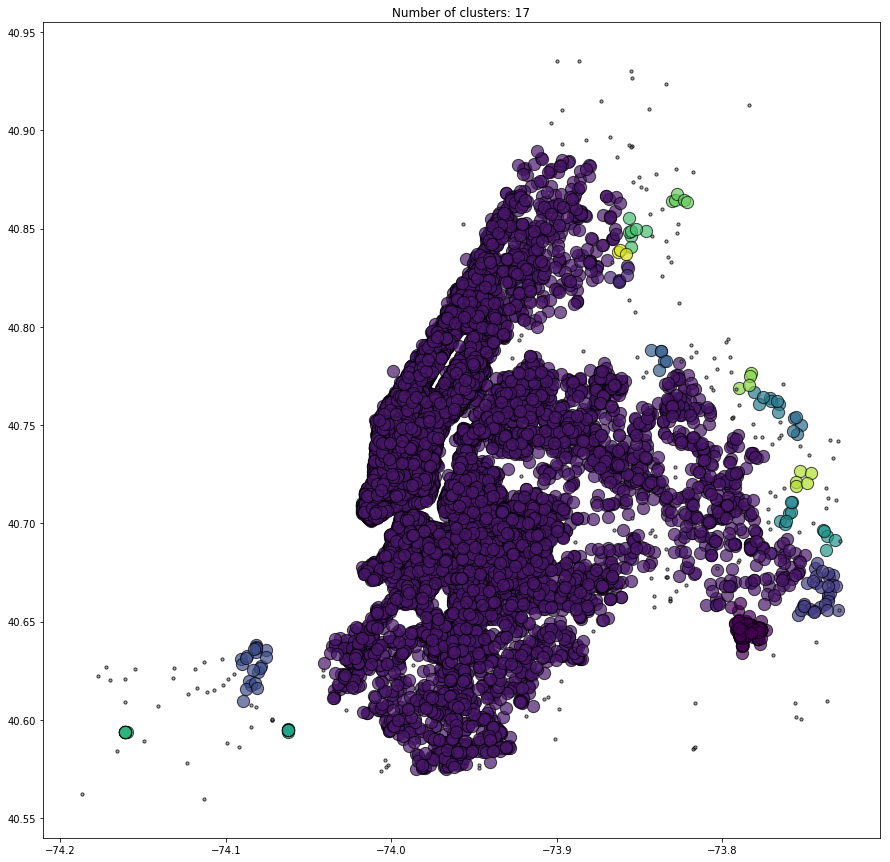

In [0]:
eps=[0.0055,0.007]
min_sam=[4,5]
result=[]
kms_per_radian = 6371.0088

for ep in eps:
  for min_sample in min_sam:
    #epsilon = ep / kms_per_radian
    epsilon=ep
    db = DBSCAN(eps=epsilon, min_samples=min_sample, algorithm='ball_tree', metric='euclidean').fit(coords)
    cluster_labels = db.labels_
    print(cluster_labels)
    unique_labels = set(cluster_labels)
    print(unique_labels)
    # get the number of clusters
    #num_clusters = len(set(cluster_labels))
    num_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    dataframe={}
    dataframe["epsilon"]=ep
    dataframe["min_samples"]=min_sample
    dataframe["number_of_clusters"]=num_clusters_

    # get colors and plot all the points, color-coded by cluster (or gray if not in any cluster, aka noise)
    fig, ax = plt.subplots(figsize=[15,15])
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

    # for each cluster label and color, plot the cluster's points
    for cluster_label, color in zip(unique_labels, colors):

        size = 150
        if cluster_label == -1: #make the noise (which is labeled -1) appear as smaller gray points
            color = 'gray'
            size = 10

        # plot the points that match the current cluster label
        x_coords = coords[cluster_labels==cluster_label][:,1]
        y_coords = coords[cluster_labels==cluster_label][:,0]
        ax.scatter(x=x_coords, y=y_coords, c=[color], edgecolor='k', s=size, alpha=0.7)

    ax.set_title('Number of clusters: {}'.format(num_clusters_))
    coefficient = metrics.silhouette_score(coords, cluster_labels)
    dataframe["silhoutte_score"]=coefficient
    result.append(dataframe)
    print('Number of samples='+str(min_sample)+',epsilon= '+str(ep)+' Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))
    plt.show()
  


In [0]:
cr=pd.DataFrame(result)

print("this  ",cr)
print("Best Result is ")
print(cr[cr.silhoutte_score==cr.silhoutte_score.max()])
d_best=cr[cr.silhoutte_score==cr.silhoutte_score.max()]
for i in d_best['epsilon']:
  ep_best=i
  break
for j in d_best['min_samples']:
  m=j
  break
for k in d_best['number_of_clusters']:
  no=k
  break
epsilon2 = ep_best
db2 = DBSCAN(eps=epsilon2, min_samples=m, algorithm='ball_tree', metric='euclidean').fit(coords)
cluster_labels = db2.labels_
df['cluster_id']=cluster_labels
centroids = []
for i in range(0,no):
  temp_df = df[df["cluster_id"]==i]
  cent_latitude = temp_df["start_lat"].value_counts().argmax()
  cent_longitude = temp_df["start_lng"].value_counts().argmax()
  centroids.append((cent_latitude,cent_longitude))

this      epsilon  min_samples  number_of_clusters  silhoutte_score
0   0.0055            4                  42         0.322372
1   0.0055            5                  32         0.249744
2   0.0070            4                  20         0.397068
3   0.0070            5                  17         0.448136
Best Result is 
   epsilon  min_samples  number_of_clusters  silhoutte_score
3    0.007            5                  17         0.448136


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


In [0]:
df3=pd.DataFrame(centroids)
list_of_places = []
import requests
for i in range(len(centroids)):
  query = 'https://nominatim.openstreetmap.org/reverse?format=jsonv2&lat=' + str(centroids[i][0]) + '&lon=' + str(centroids[i][1])
  r = requests.get(query).json()
  print(r["display_name"])
  list_of_places.append(r["display_name"])
  
  
  

John F. Kennedy International Airport, JFK Expressway, Queens, Queens County, NYC, New York, 11430, USA
215, East Broadway, Lower East Side, Manhattan Community Board 3, Manhattan, New York County, NYC, New York, 10002, USA
880, Thieriot Avenue, Clason Point, The Bronx, Bronx County, NYC, New York, 10473, United States of America
257-21, 149th Avenue, Rosedale, Queens, Queens County, NYC, New York, 11422, USA
19, Ely Street, Tompkinsville, Todt Hill, Staten Island, Richmond County, NYC, New York, 10301, USA
18-19, 125th Street, Silverpointe Estates, Queens, Queens County, NYC, New York, 11356, USA
Long Island Expressway, Oakland Gardens, Queens, Queens County, NYC, New York, 11364, USA
Starbucks, Northern Boulevard, Oakland Gardens, Queens, Queens County, NYC, New York, 11362, USA
110-38, 199th Street, Saint Albans, Queens, Queens County, NYC, New York, 11412, USA
115-104, 222nd Street, Cambria Heights, Queens, Queens County, NYC, New York, 11411, USA
62, Drury Avenue, South Beach, Tod

In [0]:
data={}
index=[]
w = folium.Map([40.738720, -73.979090], zoom_start=12)
for index, row in df3.iterrows():
    folium.CircleMarker([row[0], row[1]],
                        radius=12,
                        fill_color="#551a8b",
                        fill=True,
                        fill_opacity=0.7,
                        weight=0,
                        popup=list_of_places[index]
                       ).add_to(w)
w

In [0]:
df.head()

,time_of_trip,start_lat,start_lng,date,time,cluster_id
0,9/4/2014 9:51,40.64705,-73.77988,9/4/2014,9:51,0
1,8/27/2014 21:13,40.74916,-73.98373,8/27/2014,21:13,1
2,9/4/2014 14:16,40.64065,-73.97594,9/4/2014,14:16,1
3,9/4/2014 16:08,40.75002,-73.99514,9/4/2014,16:08,1
4,8/28/2014 2:41,40.76715,-73.98636,8/28/2014,2:41,1


In [0]:
df['time_of_trip'] =  pd.to_datetime(df['time_of_trip'], infer_datetime_format=True)
df.head()

,time_of_trip,start_lat,start_lng,date,time,cluster_id
0,2014-09-04 09:51:00,40.64705,-73.77988,9/4/2014,9:51,0
1,2014-08-27 21:13:00,40.74916,-73.98373,8/27/2014,21:13,1
2,2014-09-04 14:16:00,40.64065,-73.97594,9/4/2014,14:16,1
3,2014-09-04 16:08:00,40.75002,-73.99514,9/4/2014,16:08,1
4,2014-08-28 02:41:00,40.76715,-73.98636,8/28/2014,2:41,1


In [0]:
times = pd.Series(pd.to_datetime(df['time_of_trip'],unit='m'))
df['weekday']=times.dt.weekday_name
df['hour']=times.dt.hour.apply(lambda x: '{:02d}:00'.format(x)).fillna(0)
d=pd.crosstab(df['hour'],df['weekday'])

print(d)


weekday  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
hour                                                                   
00:00       395     280       443     387       294      275        275
01:00       422     282       443     367       316      252        236
02:00       408     294       454     413       298      226        207
03:00       376     237       455     435       251      204        173
04:00       263     193       383     373       169      144        136
05:00       163     114       352     364        90       88         83
06:00        92      64       263     296        60       53         50
07:00        55      44       169     214        40       37         13
08:00        38      29       102      97        29       19         17
09:00        30      18        51      42        24       18         18
10:00        53      47        32      25        56       50         47
11:00        78      65        48      37       102       79    

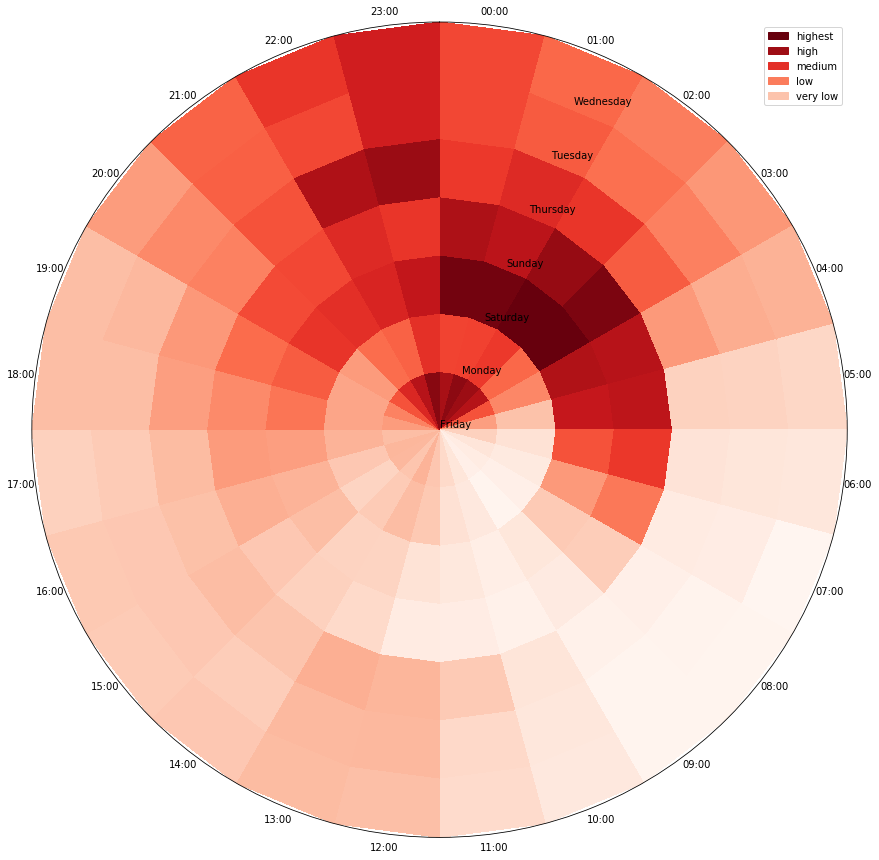

In [0]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
fig.set_size_inches(15,15)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# plot data
theta, r = np.meshgrid(np.linspace(0,2*np.pi,len(d)+1),np.arange(len(d.columns)+1))
ax.pcolormesh(theta,r,d.T.values, cmap="Reds")
legend = ax.legend([rect("#67000d"),rect("#9e0d14"), rect("#e32f27"),rect("#fb7c5c"),rect("#fcc3ac"),rect("#fff5f0")], ["highest","high","medium","low","very low"])
# set ticklabels
pos,step = np.linspace(0,2*np.pi,len(d),endpoint=False, retstep=True)
pos += step/2.
ax.set_xticks(pos)
ax.set_xticklabels(d.index)

ax.set_yticks(np.arange(len(d.columns)))
ax.set_yticklabels(d.columns)
rect = lambda color: plt.Rectangle((0,0),1,1, color=color)
plt.show()